# Using Parallel Magics

IPython has a few magics to make working with your engines
a bit nicer in IPython, e.g. via a Jupyter notebook.

As always, first we start a cluster (or connect to an existing one):

In [1]:
import ipyparallel as ipp

rc = ipp.Cluster(n=4).start_and_connect_sync()
dv = rc[:]
rc.ids

Using existing profile dir: '/Users/benjaminrk/.ipython/profile_default'
Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]

Creating a Client registers the parallel magics `%px`, `%%px`, `%pxresult`, `%pxconfig`, and `%autopx`.  
These magics are initially associated with a DirectView, always associated with all currently registered engines.

First, we can execute single lines remotely with `%px`:

In [2]:
%px a=5

In [3]:
%px print(a)

[stdout:0] 5


[stdout:1] 5


[stdout:2] 5


[stdout:3] 5


In [4]:
%px a

Out[2:3]: 5

Out[0:3]: 5

Out[3:3]: 5

Out[1:3]: 5

In [5]:
with dv.sync_imports():
    import sys  # noqa

importing sys on engine(s)


In [6]:
%px from __future__ import print_function
%px print("ERROR", file=sys.stderr)

[stderr:0] ERROR


[stderr:1] ERROR


[stderr:3] ERROR


[stderr:2] ERROR


You don't have to wait for results.  The `%pxconfig` magic lets you change the default blocking/targets for the `%px` magics:

In [7]:
%pxconfig --noblock

In [8]:
%px import time
%px time.sleep(1)
%px time.time()

<AsyncResult(%px): pending>

But you will notice that this didn't output the result of the last command.
For this, we have `%pxresult`, which displays the output of the latest request:

In [9]:
%pxresult

Out[0:8]: 1635248507.7749069

Out[1:8]: 1635248507.7802722

Out[2:8]: 1635248507.780295

Out[3:8]: 1635248507.780204

Remember, an IPython engine is IPython, so you can do magics remotely as well!

In [11]:
%pxconfig --block
%px %matplotlib inline

`%%px` can be used to lower the priority of the engines to improve system performance under heavy CPU load.

In [12]:
%%px
import psutil

psutil.Process().nice(20 if psutil.POSIX else psutil.IDLE_PRIORITY_CLASS)

In [13]:
%%px
import matplotlib.pyplot as plt
import numpy as np

`%%px` can also be used as a cell magic, for submitting whole blocks.
This one acceps `--block` and `--noblock` flags to specify
the blocking behavior, though the default is unchanged.


In [14]:
dv.scatter('id', dv.targets, flatten=True)
dv['stride'] = len(dv)

In [15]:
%%px --noblock
x = np.linspace(0, np.pi, 1000)
for n in range(id, 12, stride):
    print(n)
    plt.plot(x, np.sin(n * x))
plt.title("Plot %i" % id)

<AsyncResult(%px): pending>

[stdout:0] 
0
4
8
[stdout:1] 
1
5
9
[stdout:2] 
2
6
10
[stdout:3] 
3
7
11


[output:0]

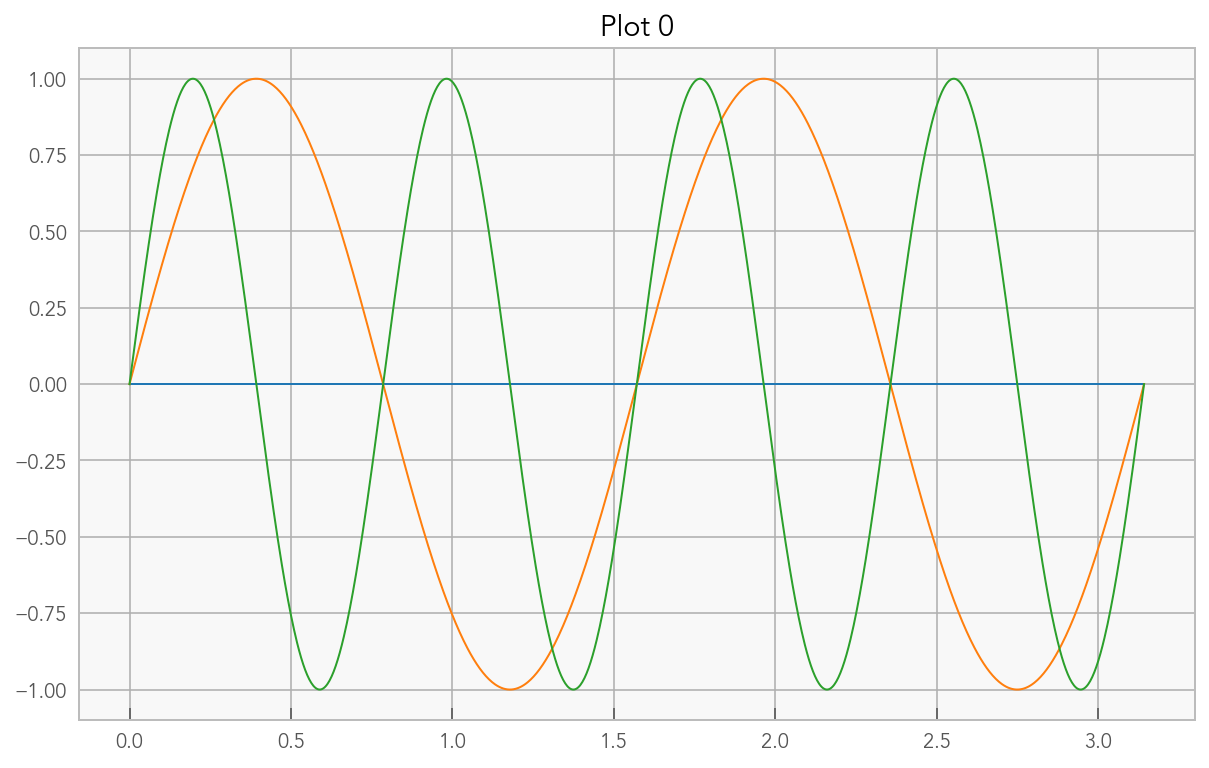

[output:1]

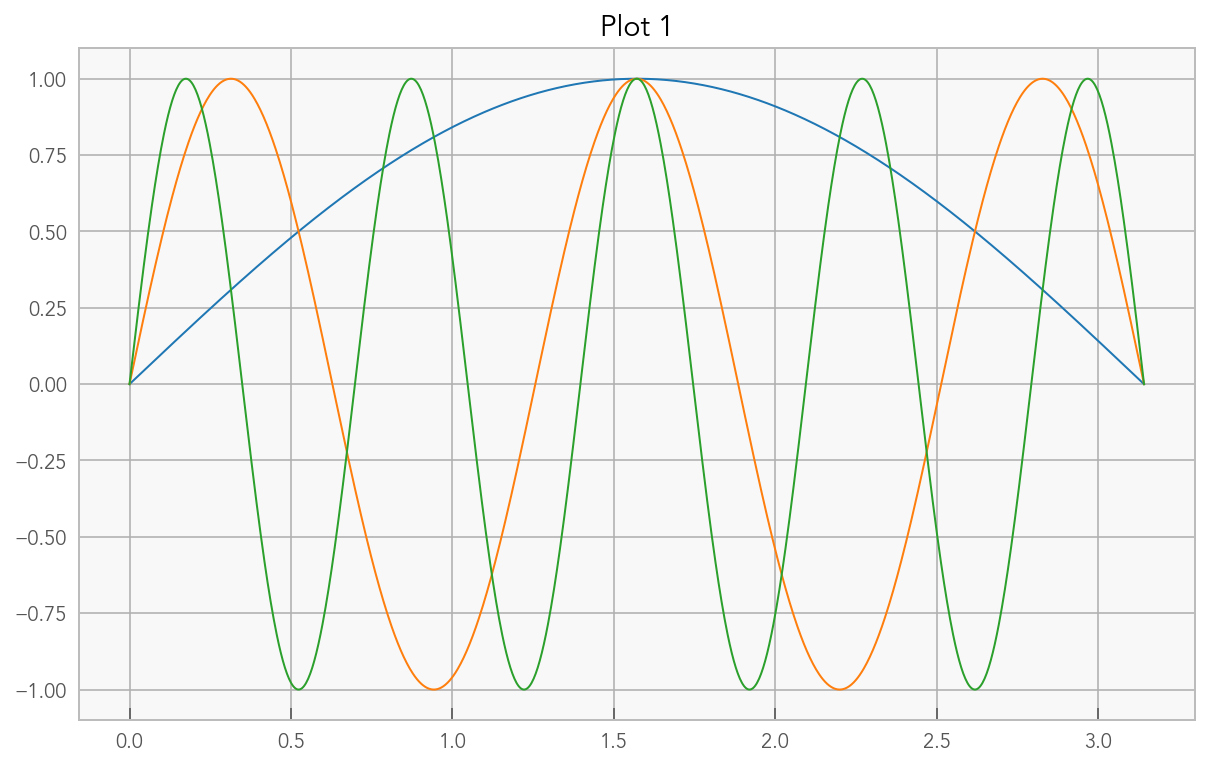

[output:2]

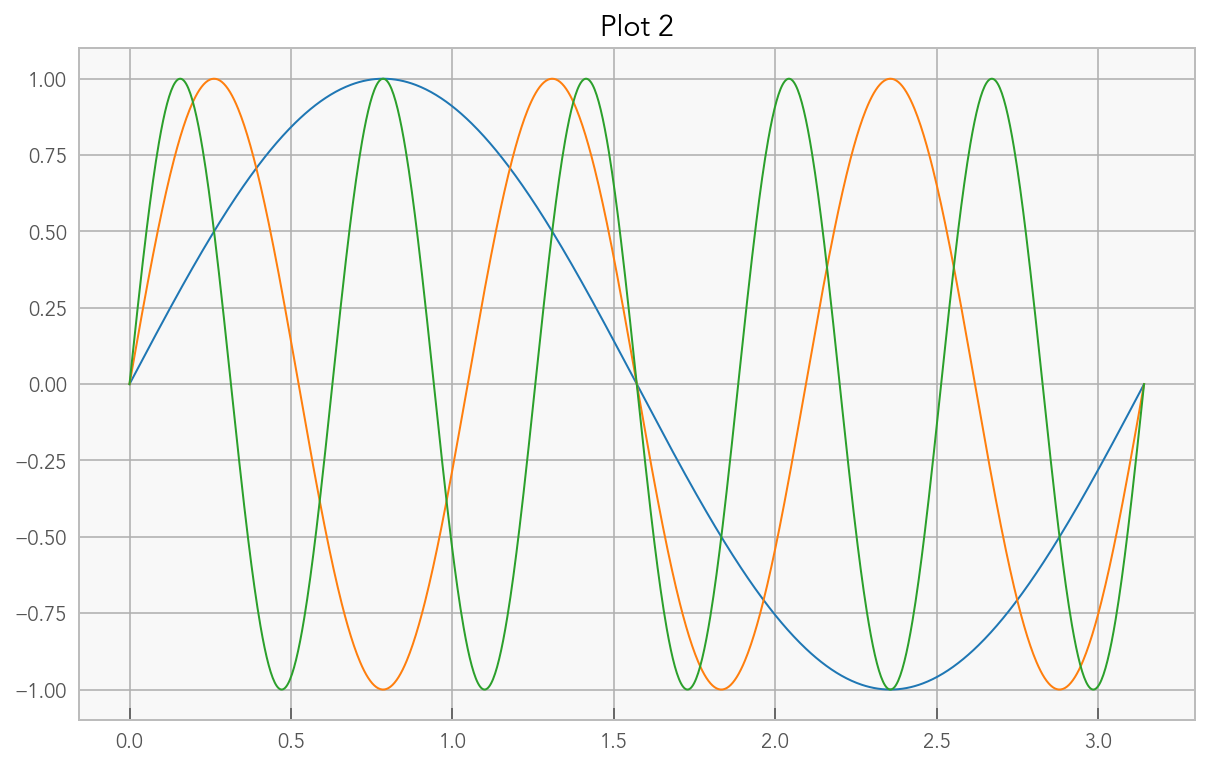

[output:3]

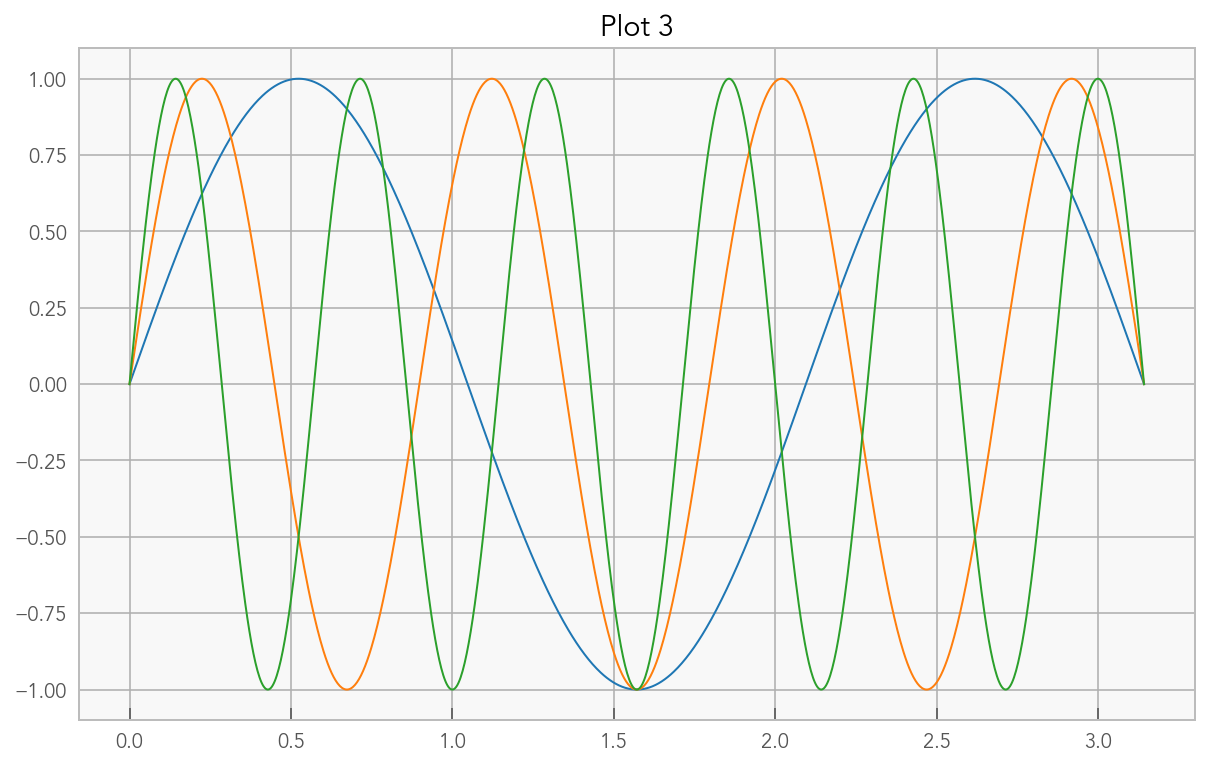

Out[0:13]: Text(0.5, 1.0, 'Plot 0')

Out[1:13]: Text(0.5, 1.0, 'Plot 1')

Out[2:13]: Text(0.5, 1.0, 'Plot 2')

Out[3:13]: Text(0.5, 1.0, 'Plot 3')

In [16]:
%pxresult

It also lets you choose some amount of the grouping of the outputs with `--group-outputs`:

The choices are:

* `engine` - all of an engine's output is collected together
* `type` - where stdout of each engine is grouped, etc. (the default)
* `order` - same as `type`, but individual displaypub outputs are interleaved.
  That is, it will output the first plot from each engine, then the second from each,
  etc.

[stdout:0] 1
5
9


[stdout:1] 2
6
10


[stdout:2] 3
7
11


[stdout:3] 4
8


[output:3]

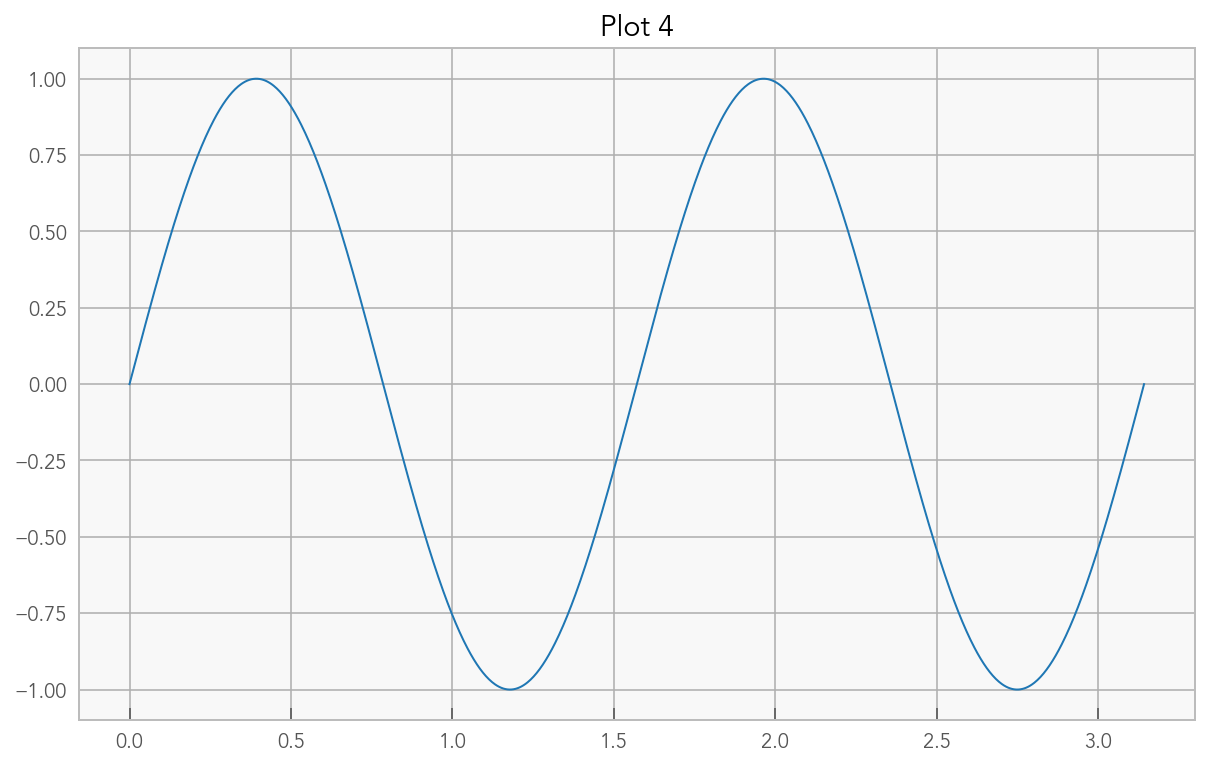

[output:0]

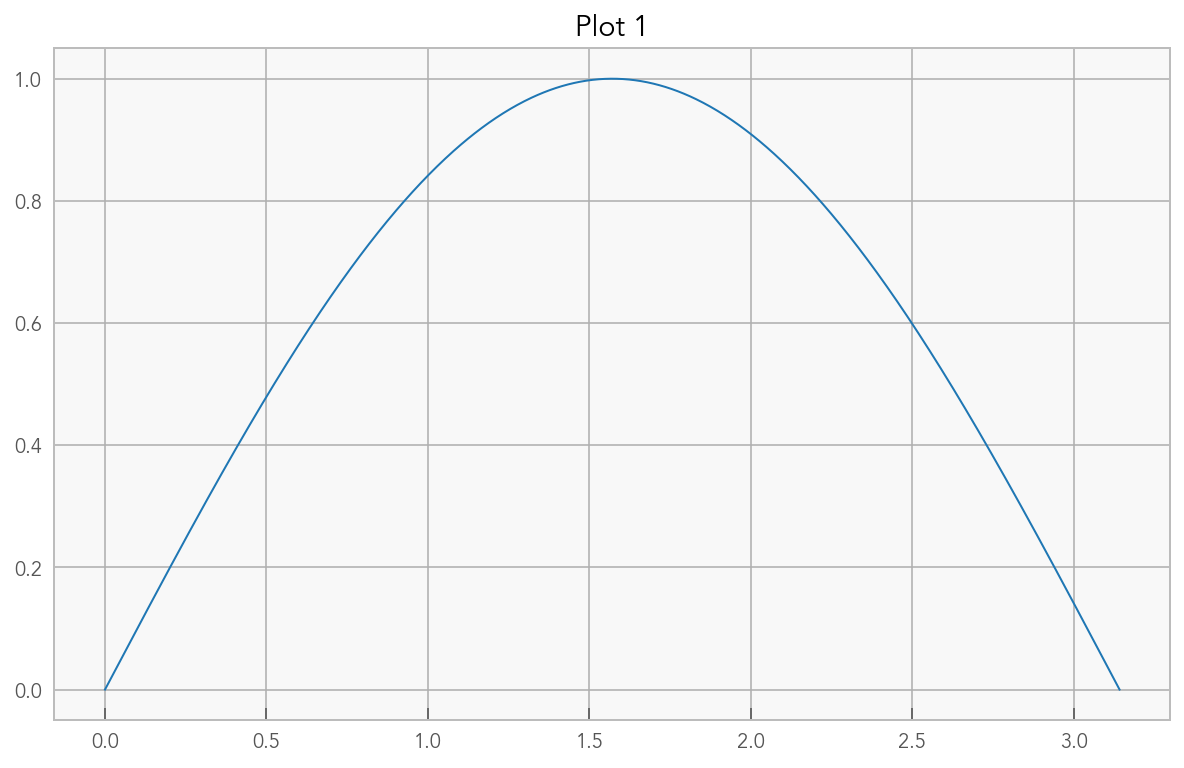

[output:1]

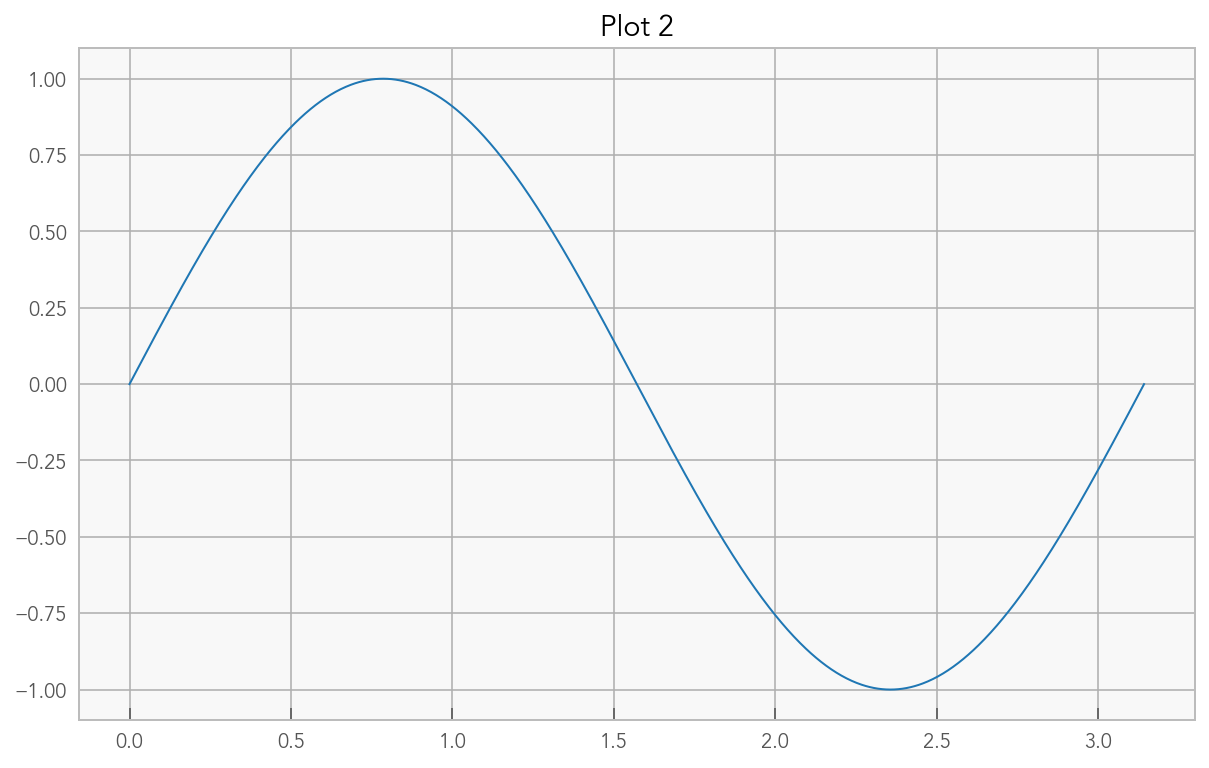

[output:2]

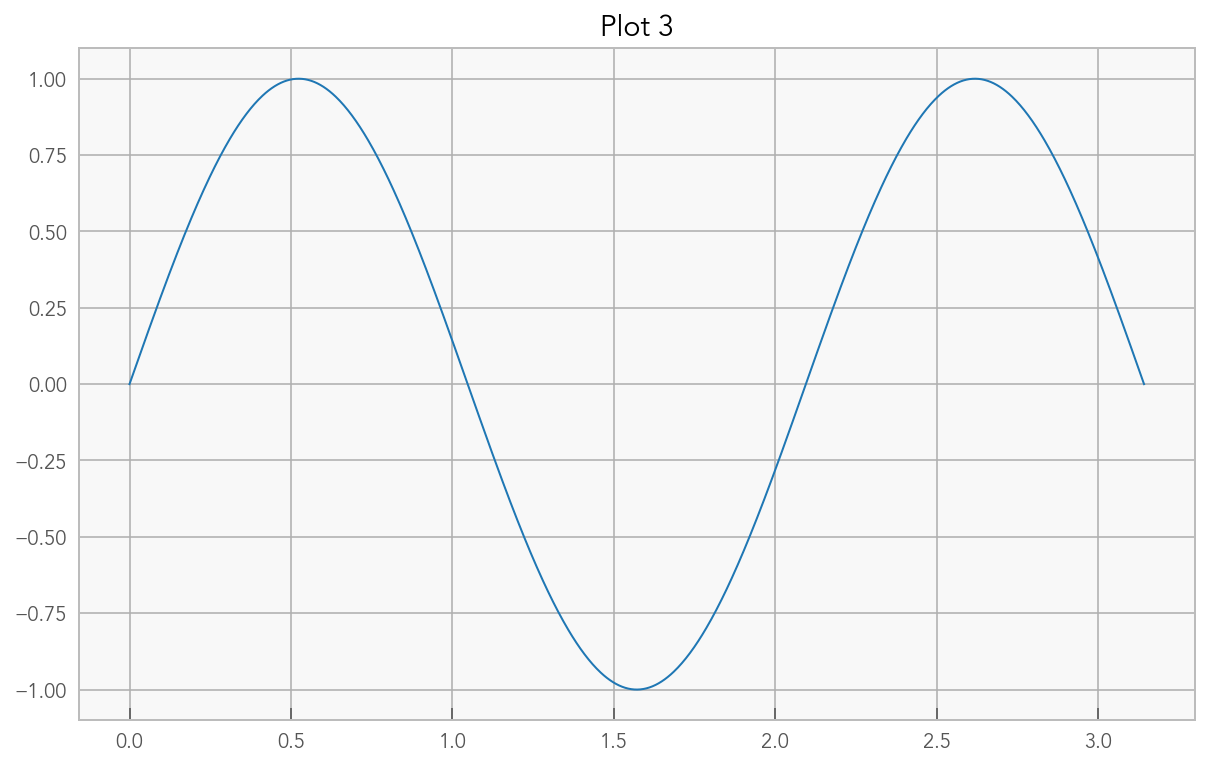

[output:3]

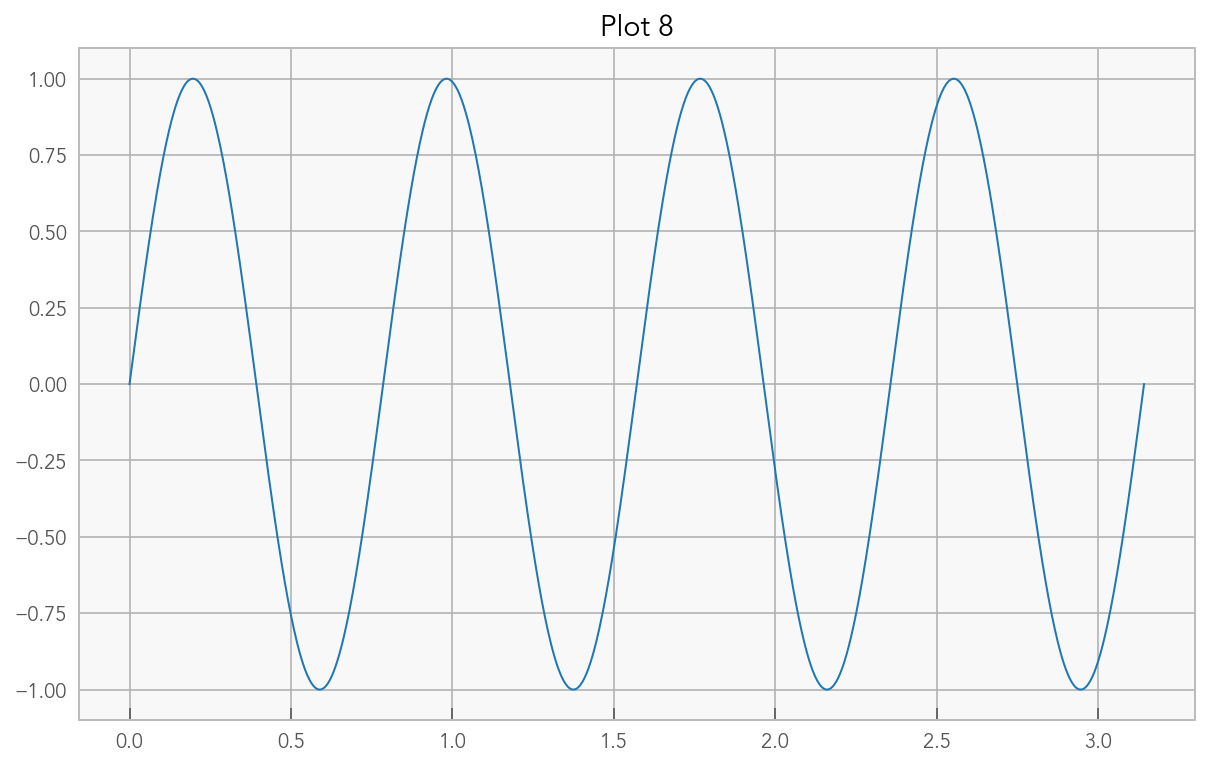

[output:0]

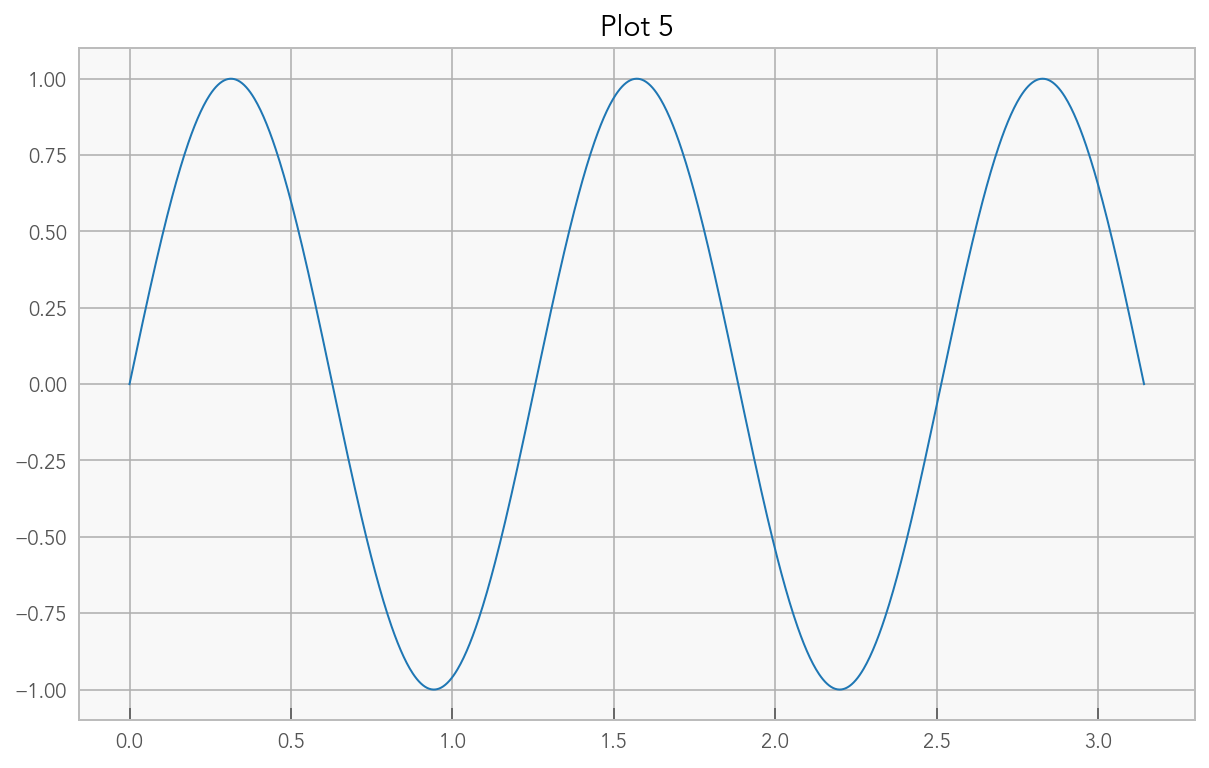

[output:1]

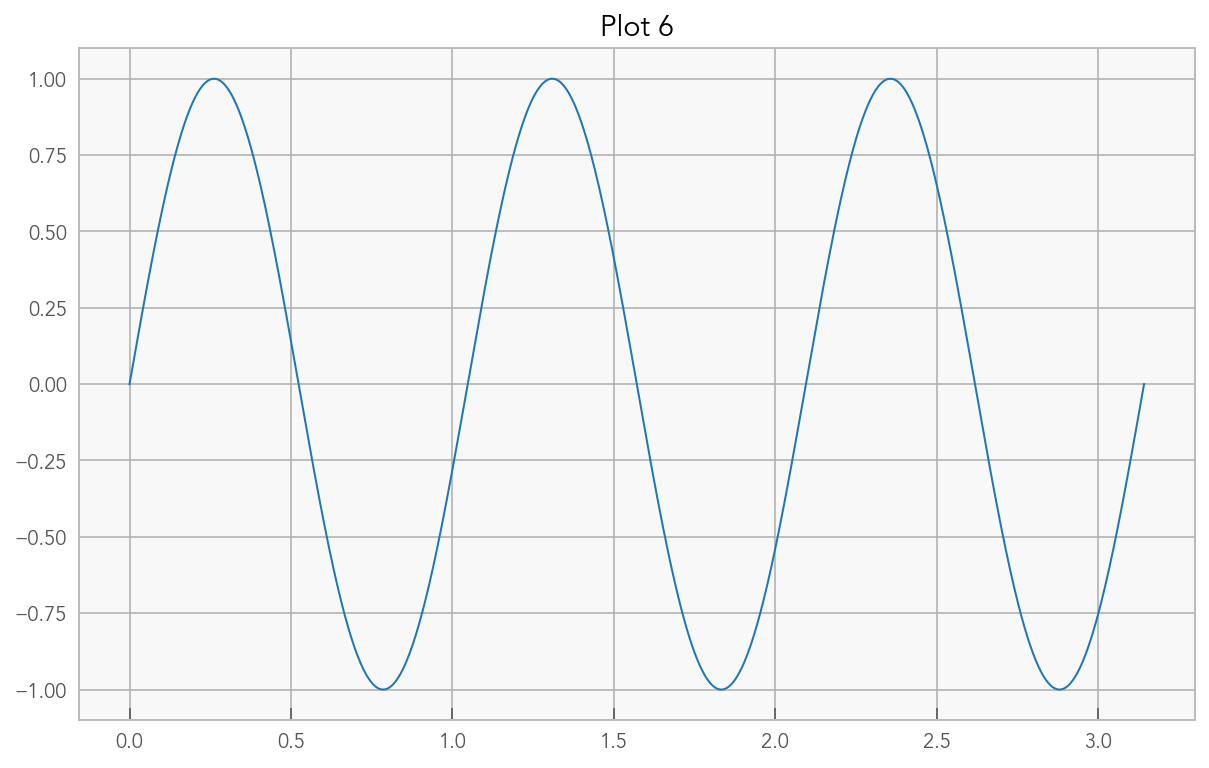

[output:2]

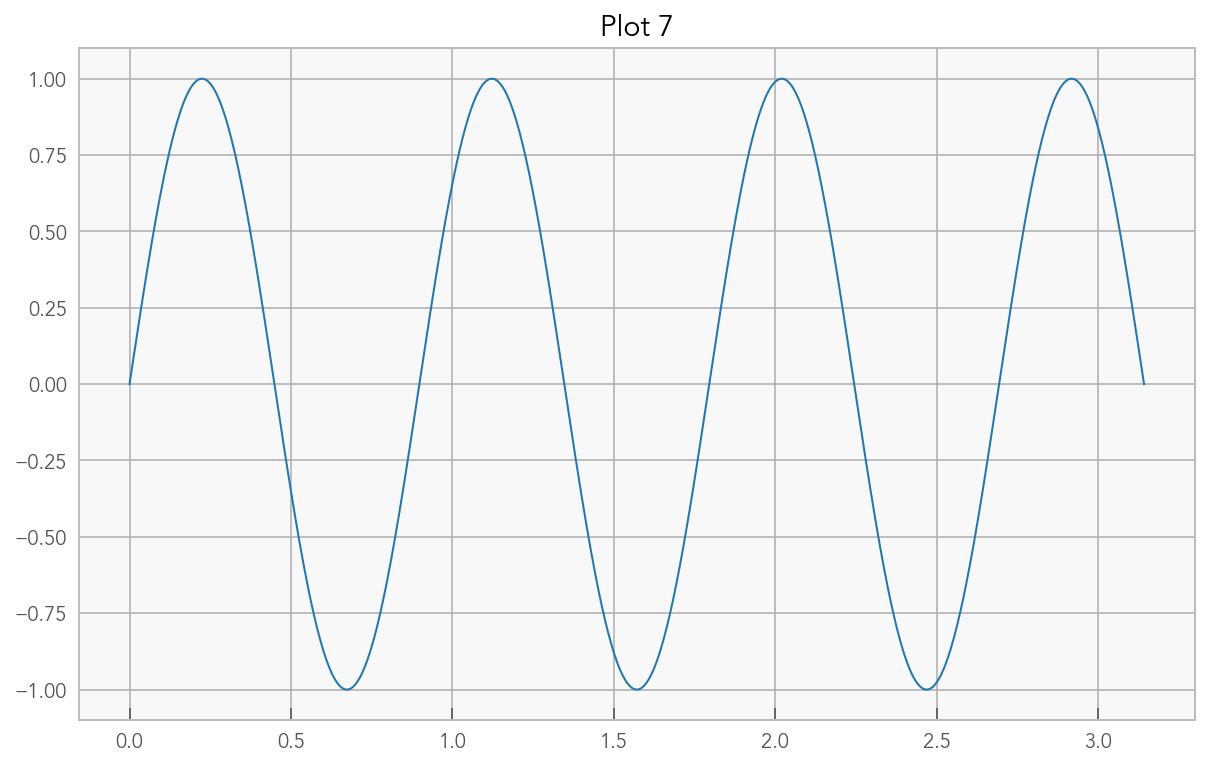

[output:0]

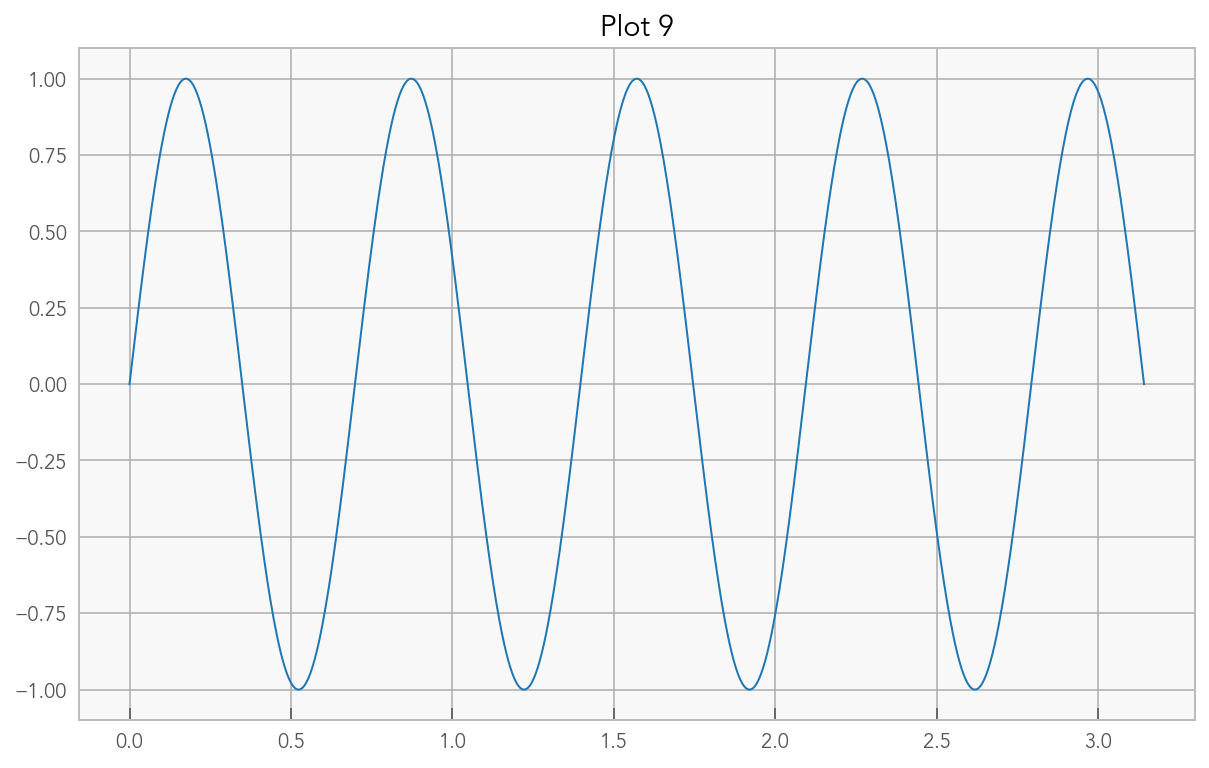

[output:1]

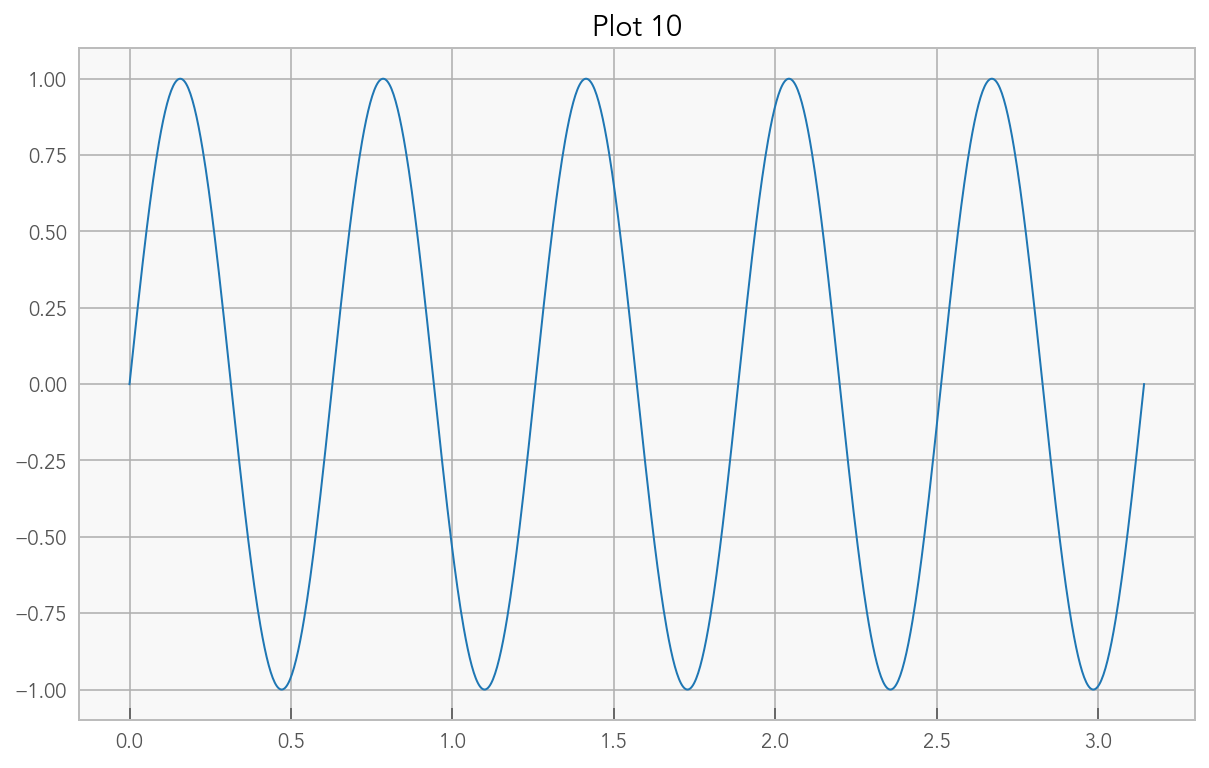

[output:2]

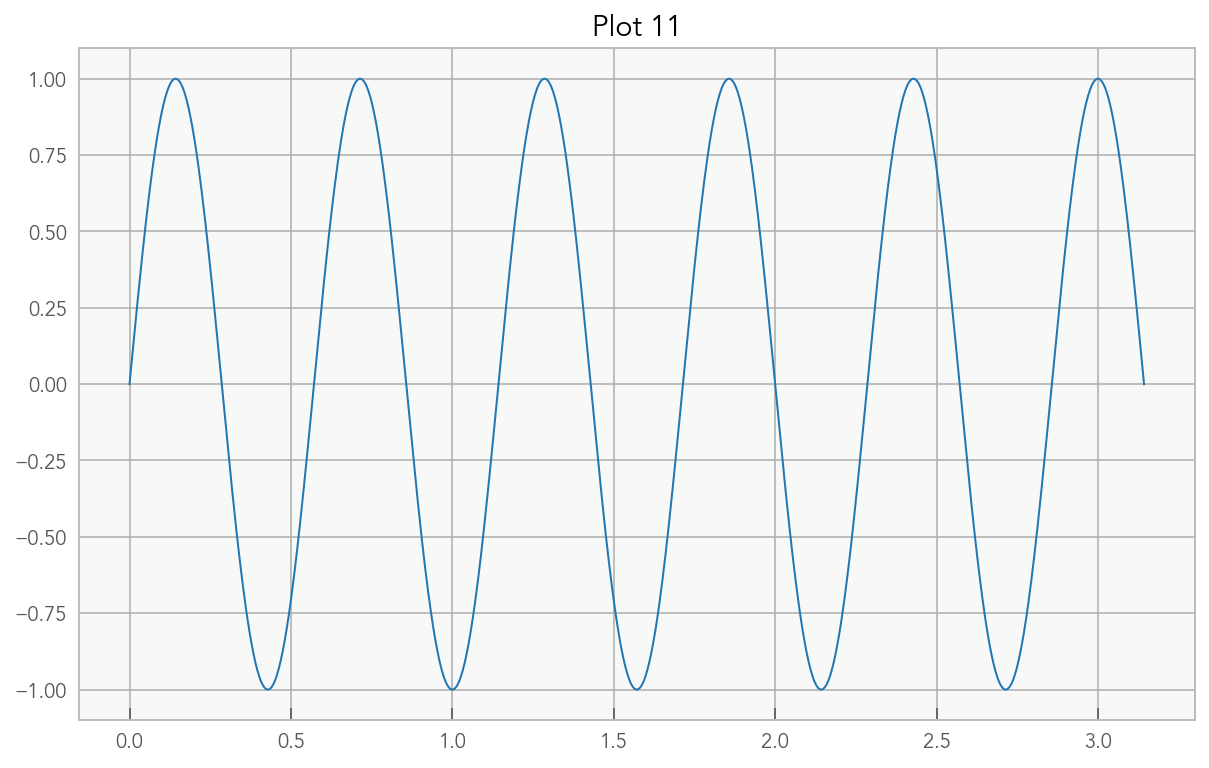

In [17]:
%%px --group-outputs=engine
x = np.linspace(0, np.pi, 1000)
for n in range(id + 1, 12, stride):
    print(n)
    plt.figure()
    plt.plot(x, np.sin(n * x))
    plt.title("Plot %i" % n)

When you specify 'order', then individual display outputs (e.g. plots) will be interleaved.

`%pxresult` takes the same output-ordering arguments as `%%px`, 
so you can view the previous result in a variety of different ways with a few sequential calls to `%pxresult`:

[stdout:0] 
1
5
9
[stdout:1] 
2
6
10
[stdout:2] 
3
7
11
[stdout:3] 
4
8


[output:0]

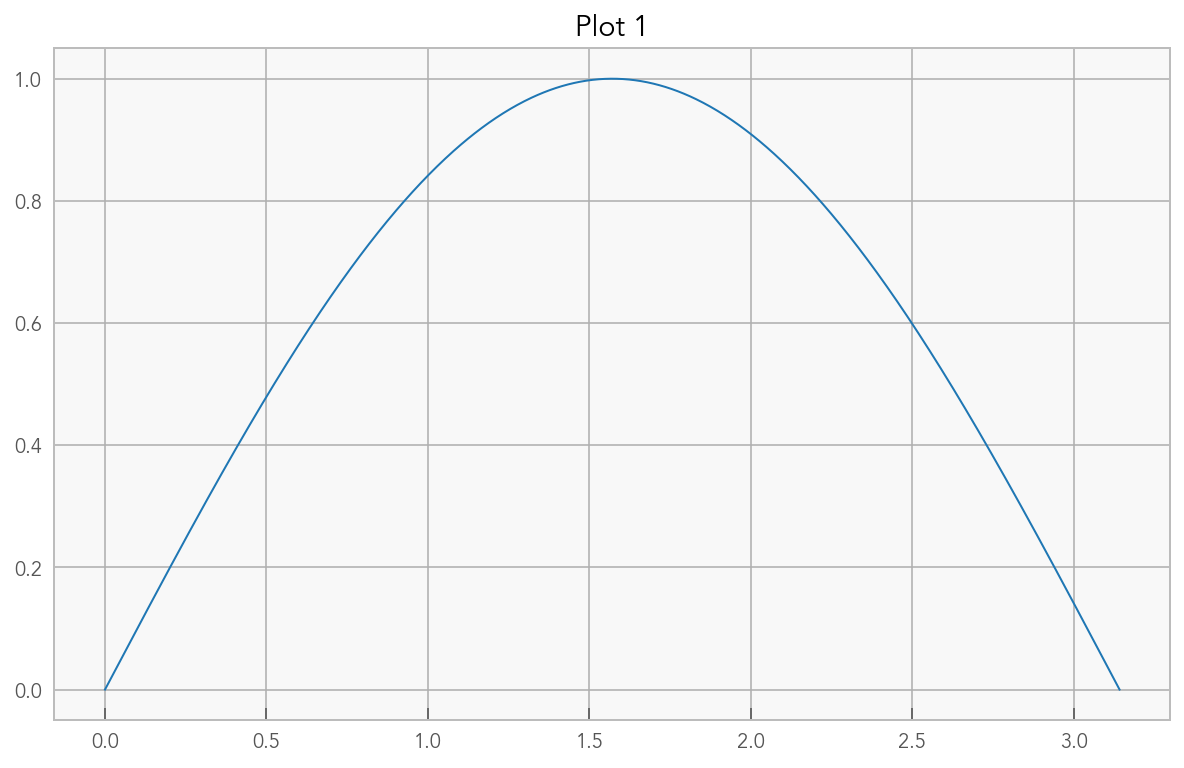

[output:1]

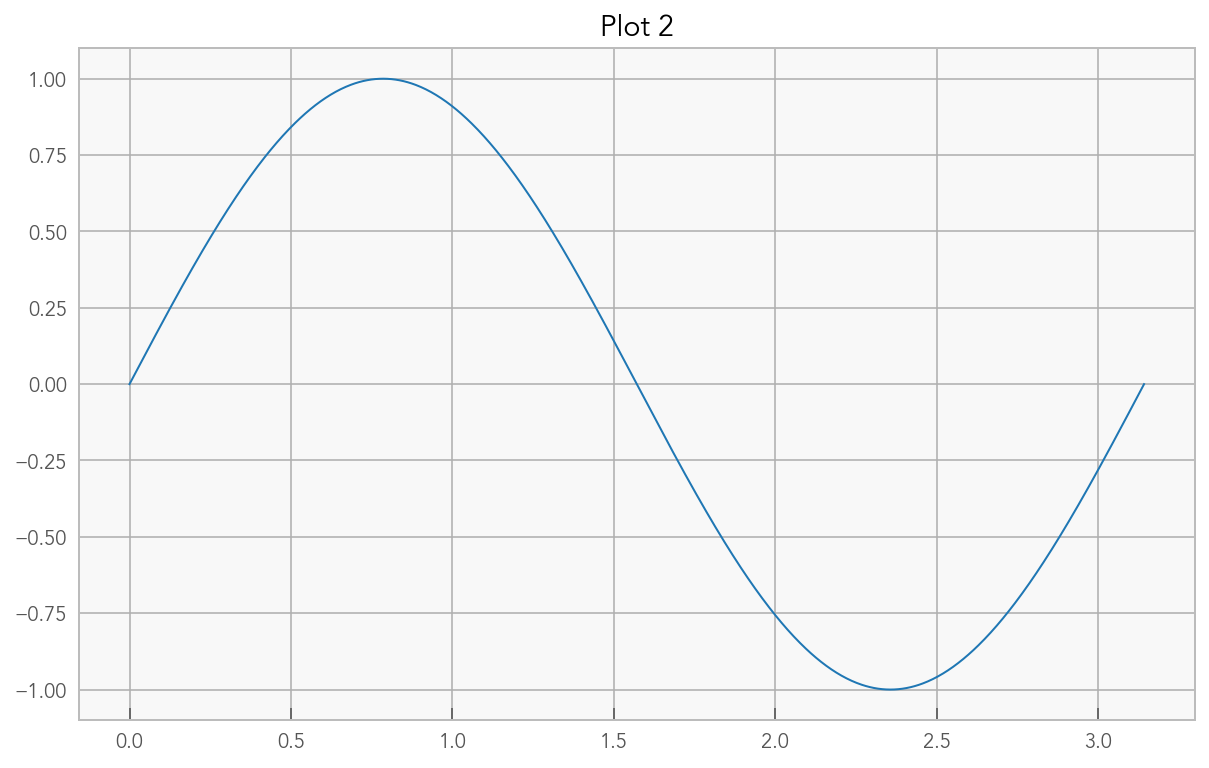

[output:2]

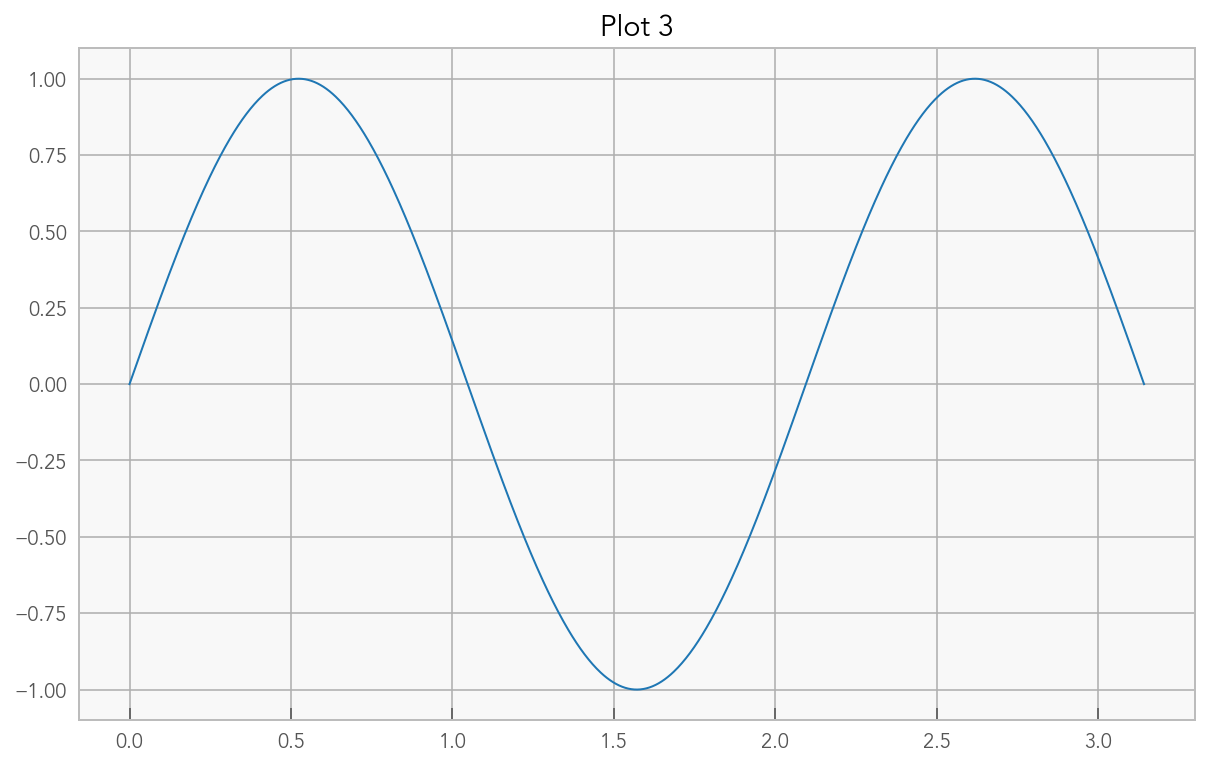

[output:0]

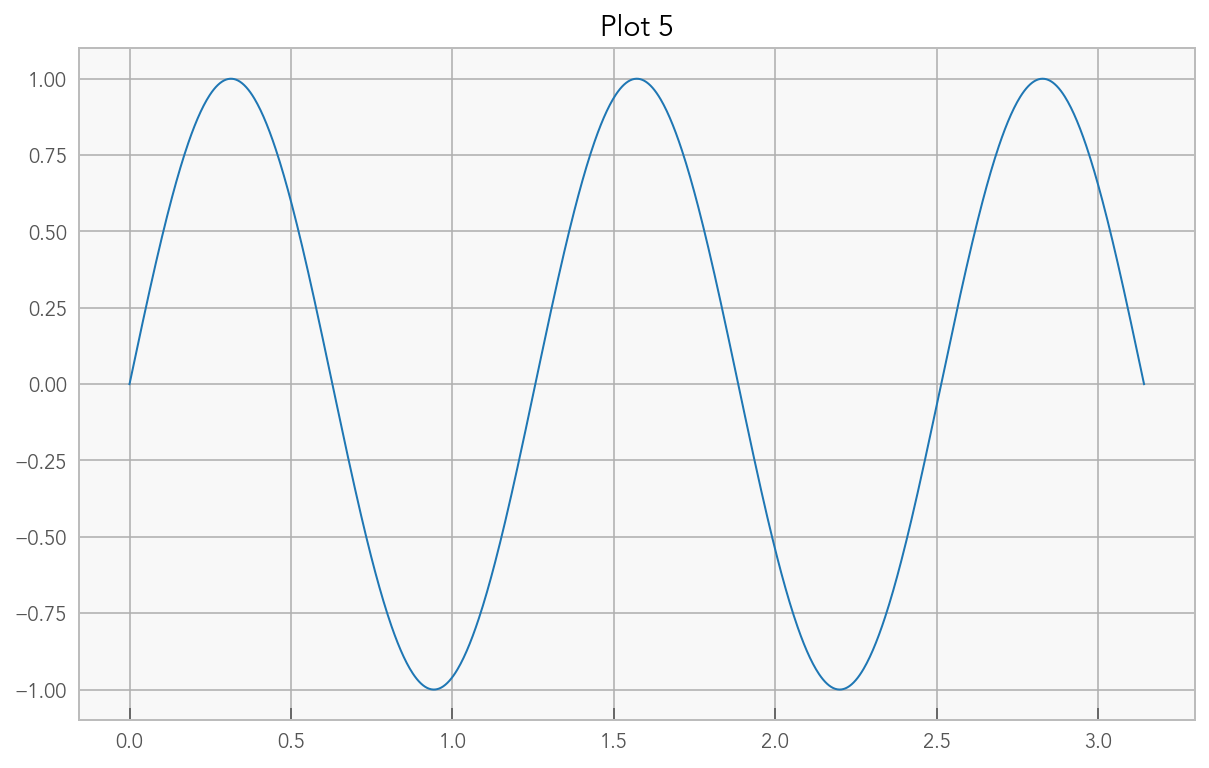

[output:1]

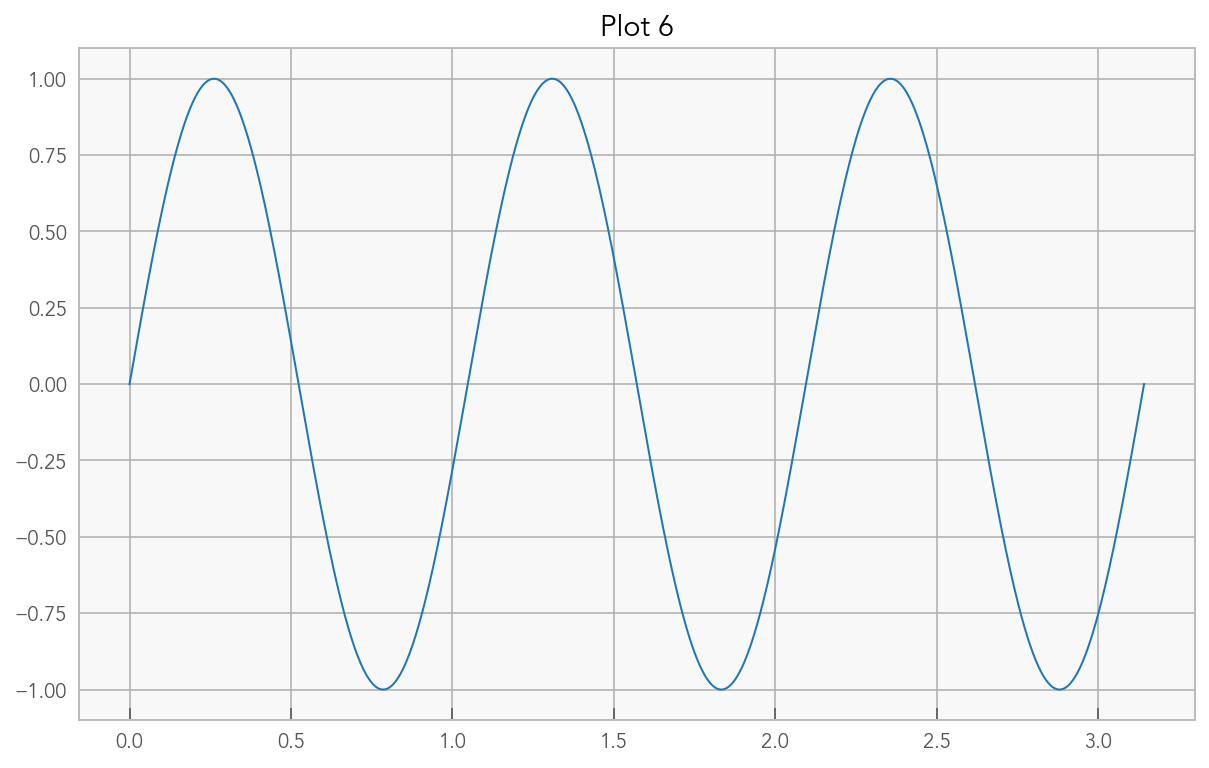

[output:2]

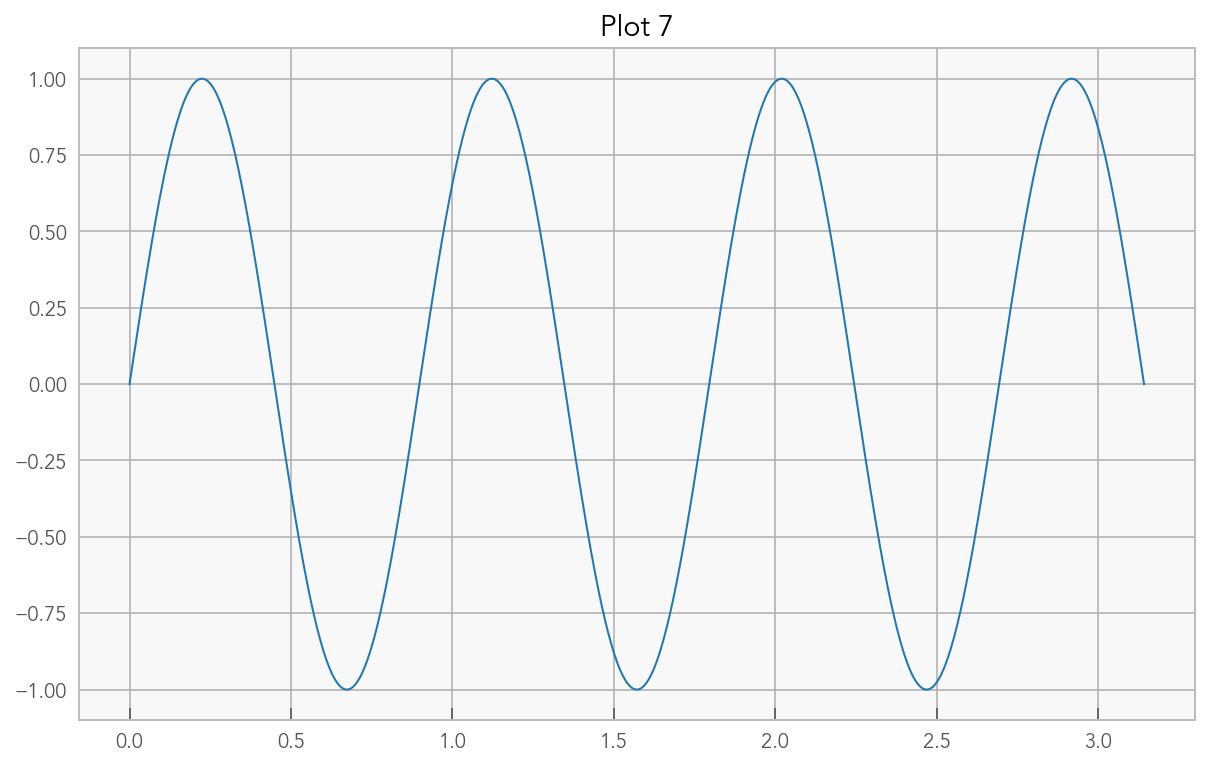

[output:0]

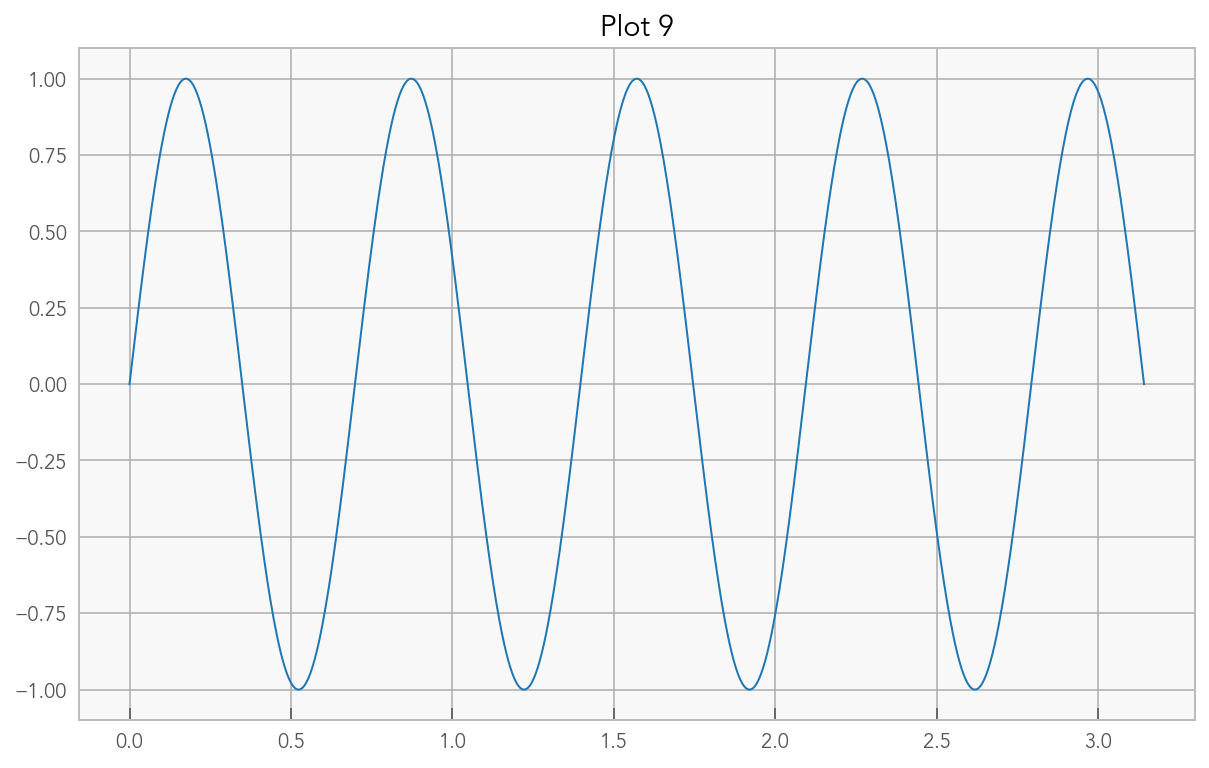

[output:1]

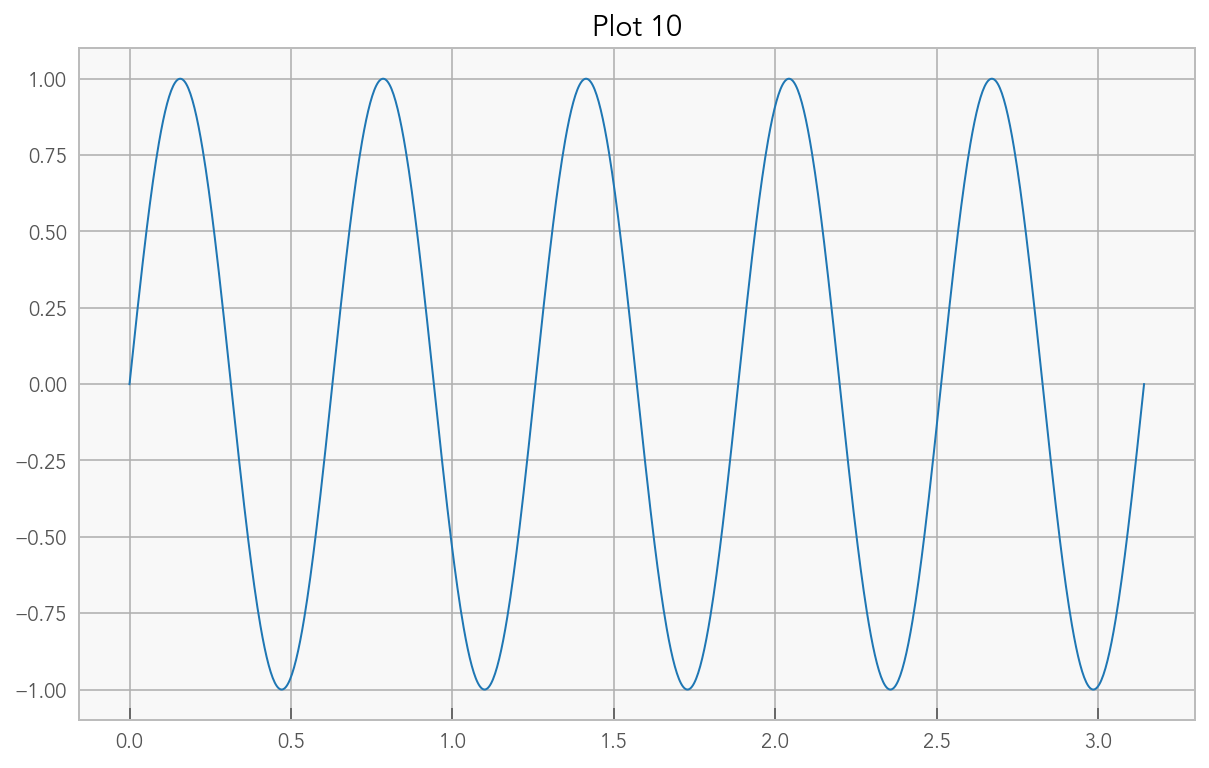

[output:2]

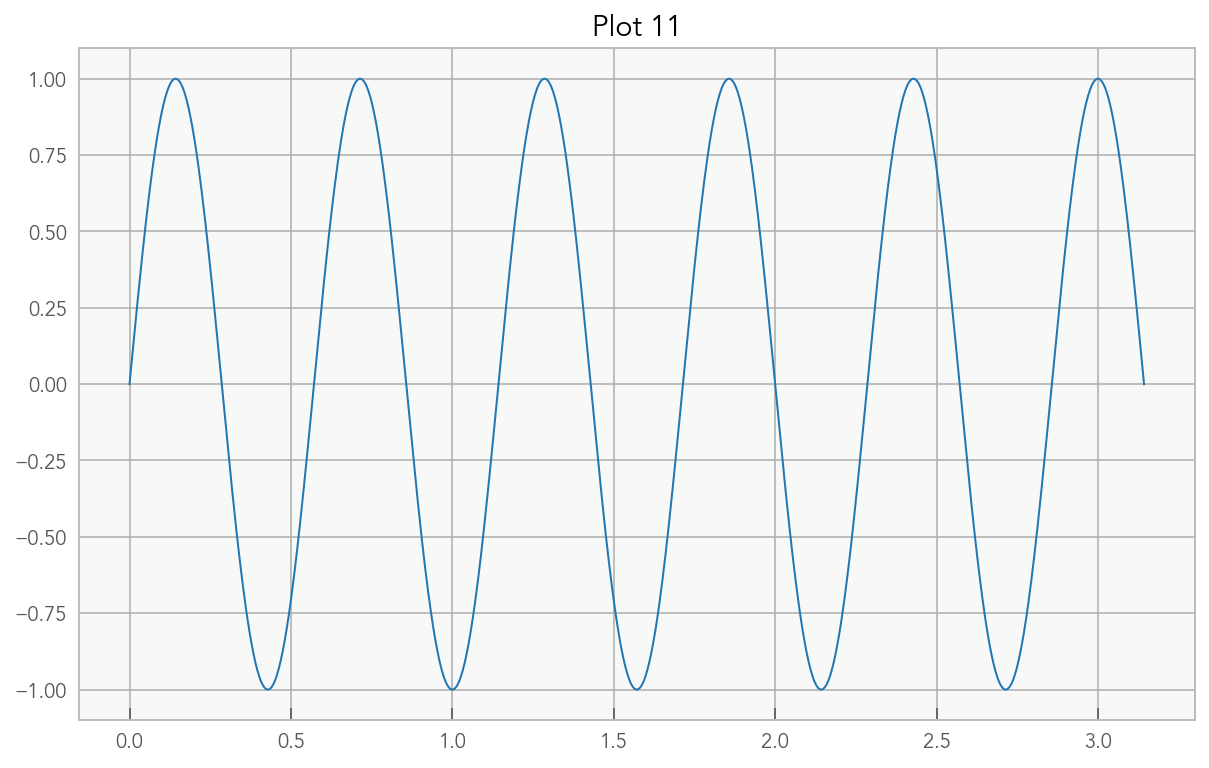

In [18]:
%pxresult --group-outputs=order

## Single-engine views

When a DirectView has a single target, the output is a bit simpler (no prefixes on stdout/err, etc.):

In [19]:
def generate_output():
    """function for testing output

    publishes two outputs of each type, and returns something
    """

    import os
    import sys

    from IPython.display import HTML, Math, display

    print("stdout")
    print("stderr", file=sys.stderr)

    display(HTML("<b>HTML</b>"))

    print("stdout2")
    print("stderr2", file=sys.stderr)

    display(Math(r"\alpha=\beta"))

    return os.getpid()


dv['generate_output'] = generate_output

You can also have more than one set of parallel magics registered at a time.

The `View.activate()` method takes a suffix argument, which is added to `'px'`.

In [20]:
e0 = rc[-1]
e0.block = True
e0.activate('0')

In [21]:
%px0 generate_output()

[stdout:3] stdout
stdout2


[stderr:3] stderr
stderr2


[output:3]

[output:3]

<IPython.core.display.Math object>

Out[3:15]: 83115

In [22]:
%px generate_output()

[stdout:0] stdout
stdout2


[stdout:1] stdout
stdout2


[stdout:2] stdout
stdout2


[stderr:2] stderr
stderr2


[stdout:3] stdout
stdout2


[stderr:0] stderr
stderr2


[output:0]

[stderr:1] stderr
stderr2


[output:1]

[stderr:3] stderr
stderr2


[output:2]

[output:3]

[output:0]

<IPython.core.display.Math object>

[output:1]

<IPython.core.display.Math object>

Out[0:15]: 83112

[output:2]

<IPython.core.display.Math object>

[output:3]

<IPython.core.display.Math object>

Out[1:15]: 83113

Out[2:15]: 83114

Out[3:16]: 83115

As mentioned above, we can redisplay those same results with various grouping:

In [23]:
%pxresult --group-outputs order

[stdout:0] 
stdout
stdout2
[stdout:1] 
stdout
stdout2
[stdout:2] 
stdout
stdout2
[stdout:3] 
stdout
stdout2


[stderr:0] 
stderr
stderr2
[stderr:1] 
stderr
stderr2
[stderr:2] 
stderr
stderr2
[stderr:3] 
stderr
stderr2


[output:0]

[output:1]

[output:2]

[output:3]

[output:0]

<IPython.core.display.Math object>

[output:1]

<IPython.core.display.Math object>

[output:2]

<IPython.core.display.Math object>

[output:3]

<IPython.core.display.Math object>

Out[0:15]: 83112

Out[1:15]: 83113

Out[2:15]: 83114

Out[3:16]: 83115

In [24]:
%pxresult --group-outputs engine

[stdout:0] 
stdout
stdout2


[stderr:0] 
stderr
stderr2


[output:0]

<IPython.core.display.Math object>

Out[0:15]: 83112

[stdout:1] 
stdout
stdout2


[stderr:1] 
stderr
stderr2


[output:1]

<IPython.core.display.Math object>

Out[1:15]: 83113

[stdout:2] 
stdout
stdout2


[stderr:2] 
stderr
stderr2


[output:2]

<IPython.core.display.Math object>

Out[2:15]: 83114

[stdout:3] 
stdout
stdout2


[stderr:3] 
stderr
stderr2


[output:3]

<IPython.core.display.Math object>

Out[3:16]: 83115

## Parallel Exceptions

When you raise exceptions with the parallel exception,
the CompositeError raised locally will display your remote traceback.

In [25]:
%%px
from numpy.random import random

A = random((100, 100, 'invalid shape'))

[0:execute]: 
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
/var/folders/9p/clj0fc754y35m01btd46043c0000gn/T/ipykernel_83112/1064401740.py in <module>
      1 from numpy.random import random
----> 2 A = random((100, 100, 'invalid shape'))

mtrand.pyx in numpy.random.mtrand.RandomState.random()

mtrand.pyx in numpy.random.mtrand.RandomState.random_sample()

_common.pyx in numpy.random._common.double_fill()

TypeError: 'str' object cannot be interpreted as an integer
[2:execute]: 
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
/var/folders/9p/clj0fc754y35m01btd46043c0000gn/T/ipykernel_83114/1064401740.py in <module>
      1 from numpy.random import random
----> 2 A = random((100, 100, 'invalid shape'))

mtrand.pyx in numpy.random.mtrand.RandomState.random()

mtrand.pyx in numpy.ra

AlreadyDisplayedError: 4 errors

Sometimes, an error will occur on just one engine,
while the rest are still working.

When this happens, you will see errors immediately,
and can interrupt the execution:

In [26]:
dv.scatter("rank", rc.ids, flatten=True)

<AsyncResult(scatter): pending>

In [27]:
%%px
import time

if rank == 0:
    raise RuntimeError("rank 0 failed!")
time.sleep(10)

[0:execute]: 
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
/var/folders/9p/clj0fc754y35m01btd46043c0000gn/T/ipykernel_83112/2811384868.py in <module>
      1 import time
      2 if rank == 0:
----> 3     raise RuntimeError("rank 0 failed!")
      4 time.sleep(10)
      5 

RuntimeError: rank 0 failed!


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

AlreadyDisplayedError: 1 errors

## Remote Cell Magics

Remember, Engines are IPython too, so the cell that is run remotely by %%px can in turn use a cell magic.

In [28]:
%%px
%%timeit
from numpy.random import random
from numpy.linalg import norm
A = random((100, 100))
norm(A, 2)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:1] 6.01 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[stdout:0] 6.02 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[stdout:3] 6.06 ms ± 580 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[stdout:2] 6.08 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Local Execution

You can instruct `%%px` to also execute the cell locally.
This is useful for interactive definitions,
or if you want to load a data source everywhere,
not just on the engines.

In [29]:
%%px --local
import os

thispid = os.getpid()
print(thispid)

83088
[stdout:0] 
83112
[stdout:1] 
83113
[stdout:2] 
83114
[stdout:3] 
83115
